### Pruning and Fine-tuning in Low Data regime
VGG16 pre-trained on Imagenet and fine-tuned on CUB-200. Pruning on a low-data regime, assuming access to only 100 samples. No fine-tuning after pruning.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("./..")

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pickle
import matplotlib.pyplot as plt
from torchsummary import summary, torchsummary
from TorchPruner.experiments.utils import get_module_name, format_plt, map_method_vis, train, test
import TorchPruner.experiments.models.CUB200 as cub200

from torchpruner.pruner import Pruner
from torchpruner.utils import get_vgg_pruning_graph
from torchpruner.attributions import (
    WeightNormAttributionMetric,
    RandomAttributionMetric,
    SensitivityAttributionMetric,
    TaylorAttributionMetric,
    APoZAttributionMetric,
    ShapleyAttributionMetric,
    find_best_module_for_attributions
)

# Fix seed for reproducibility
torch.manual_seed(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(1)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:2" if use_cuda else "cpu")
print (f"Using device: {device}")

Using device: cuda:2


In [ ]:
# Get pretrained weights (in case of error, visit the url manualy)
!wget -O weights/CUB200-VGG16.pt "hhttps://drive.google.com/uc?id=1eobVyAs1fgO_nO8XuM2X_TQ0Rp4ibDCj&export=download"

In [ ]:
def get_loaders():
    _, test_set = cub200.get_dataset()
    # Using only 1000 samples from test set to build a dataset for pruning and fine-tuning
    test_set, reduced_train_set = torch.utils.data.random_split(test_set, [len(test_set)-200, 200])
    # Further split the new reduced train set into train and validation
    train_set, val_set = torch.utils.data.random_split(reduced_train_set, [len(reduced_train_set)-100, 100])

    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=50, shuffle=True,
    )
    val_loader = torch.utils.data.DataLoader(
        val_set, batch_size=50, shuffle=False,
    )
    test_loader = torch.utils.data.DataLoader(
        test_set, batch_size=50, shuffle=False,
    )
    return train_loader, val_loader, test_loader
    
loss = cub200.loss
input_size = (3, 224, 224)
lr = 0.001
# Load pretrained model
def load_model():
    model, name = cub200.get_model_with_name()
    # Load weights
    model.load_state_dict(torch.load("weights/CUB200-VGG16.pt"))
    model = model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    model.eval()
    return model, optimizer

# Display architecture and test performance
model, opt = load_model()
# summary(model, input_size=input_size, device=device)
train_loader, val_loader, test_loader = get_loaders()

In [9]:
# Initialize attribution metrics that will be used
methods = {
    "Taylor" : TaylorAttributionMetric(model, val_loader, loss, device),
    #"Taylor signed" : TaylorAttributionMetric(model, val_loader, loss, device, signed=True),
    "APoZ" : APoZAttributionMetric(model, val_loader, loss, device),
    #"SV" : ShapleyAttributionMetric(model, val_loader, loss, device),
    "SV mean+2std" : ShapleyAttributionMetric(model, val_loader, loss, device, 
                                             reduction=lambda x: np.mean(x, 0) + 2*np.std(x, 0)),
    "Weight Norm" : WeightNormAttributionMetric(model, val_loader, loss, device),
    "Random" : RandomAttributionMetric(model, val_loader, loss, device),
    "Sensitivity" : SensitivityAttributionMetric(model, val_loader, loss, device)
}

In [11]:
%%time
from timeit import default_timer as timer

history = {}
history_pp = {}

# PR: pruning ratio (fraction of prunable units to remove at each layer)
for PR in [0.20, 0.40, 0.60]:

    history[PR] = {}
    history_pp[PR] = {}
    times = {}
    
    for r in range(3):
        
        # Run all methods 3 times with randomly sampled trining data
        train_loader, val_loader, test_loader = get_loaders()
    
        for method_name, attribution in methods.items():

            if method_name not in history[PR]:
                history[PR][method_name] = []
            if method_name not in history_pp[PR]:
                history_pp[PR][method_name] = []
            if method_name not in times:
                times[method_name] = []

            print (f"Running with '{method_name}' attribution method")
            model, optimizer = load_model()
            history[PR][method_name].append([test(model, device, loss, test_loader)])
            history_pp[PR][method_name].append([])

            # Get list of layers and cascading layers for pruning
            pruning_graph = get_vgg_pruning_graph(model)
            pruner = Pruner(model, input_size=(3,224,224), device=device)
            
            start = timer()

            # Prune all but first 4 conv layers
            for module, cascading_modules in pruning_graph:

                module_name = get_module_name(model, module)
                print (f"--> pruning {module_name}")

                # Set new model and data generator on attribution instance
                # Alternatively, a new instance could be instanciated
                attribution.data_gen = val_loader
                attribution.model = model 

                # Compute attributions and pruning indices
                scores = attribution.run(module, find_best_evaluation_module=True)
                ranking = np.argsort(scores)
                pruning_indices = ranking[:int(len(ranking) * PR)]

                # Prune
                pruner.prune_model(module, pruning_indices, cascading_modules=cascading_modules)

                # Compute new loss/accuracy of the real test set before fine-tuning
                history[PR][method_name][-1].append(test(model, device, loss, test_loader))

                # Fine-tune using early stopping 
                prev_loss, prev_acc = test(model, device, loss, val_loader)
                
                # No fine-tune
                
#                 torch.save(model.state_dict(), "data/tmp_model.pt")
#                 while True:
#                     train(model, device, loss, train_loader, optimizer, 0)
#                     new_loss, new_acc = test(model, device, loss, val_loader)
#                     if new_loss >= prev_loss:
#                         model.load_state_dict(torch.load("data/tmp_model.pt"))
#                         break
#                     prev_loss = new_loss
#                     torch.save(model.state_dict(), "data/tmp_model.pt")

                # Compute loss/accuracy of the real test set after fine-tuning
                history_pp[PR][method_name][-1].append(test(model, device, loss, test_loader))
            end = timer() - start
            times[method_name].append(end)

# Dump all results to file for later analysis
pickle.dump({"pre": history, "post": history_pp, "time": times}, open(f"data/lowdata_cub_performance_results_notune_det.p", "wb" ))

Files already downloaded and verified
Running with 'Taylor' attribution method
Test set: Average loss: 0.5626, Accuracy: 693/800 (86.625%)

--> pruning classifier.3
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 819 units from Linear(in_features=4096, out_features=200, bias=True) (in)
Pruning 819 units from Dropout(p=0.5, inplace=False) (in)
Pruning 819 units from Linear(in_features=4096, out_features=4096, bias=True) (out)
Test set: Average loss: 0.5993, Accuracy: 684/800 (85.500%)

Test set: Average loss: 0.5802, Accuracy: 86/100 (86.000%)

Test set: Average loss: 0.5993, Accuracy: 684/800 (85.500%)

--> pruning classifier.0
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 819 units from Linear(in_features=4096, out_features=4096, bias=True) (in)
Pruning 819 units from Dropout(p=0.5, inplace=False) (in)
Pruning 819 units from Linear(in_features=25088, out_features=4096, bias=True) (out)
Test set: Average loss: 0.6275, Accuracy: 675/

Test set: Average loss: 0.5626, Accuracy: 693/800 (86.625%)

--> pruning classifier.3
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 819 units from Linear(in_features=4096, out_features=200, bias=True) (in)
Pruning 819 units from Dropout(p=0.5, inplace=False) (in)
Pruning 819 units from Linear(in_features=4096, out_features=4096, bias=True) (out)
Test set: Average loss: 0.5869, Accuracy: 685/800 (85.625%)

Test set: Average loss: 0.5563, Accuracy: 84/100 (84.000%)



Test set: Average loss: 0.5869, Accuracy: 685/800 (85.625%)

--> pruning classifier.0
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 819 units from Linear(in_features=4096, out_features=4096, bias=True) (in)
Pruning 819 units from Dropout(p=0.5, inplace=False) (in)
Pruning 819 units from Linear(in_features=25088, out_features=4096, bias=True) (out)
Test set: Average loss: 0.6030, Accuracy: 680/800 (85.000%)

Test set: Average loss: 0.5542, Accuracy: 86/100 (86.000%)



Test set: Average loss: 0.6030, Accuracy: 680/800 (85.000%)

--> pruning features.40
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 4998 units from Linear(in_features=25088, out_features=4096, bias=True) (in)
Pruning 102 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 102 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.6580, Accuracy: 661/800 (82.625%)

Test set: Average loss: 0.5680, Accuracy: 85/100 (85.000%)



Test set: Average loss: 0.6580, Accuracy: 661/800 (82.625%)

--> pruning features.37
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 102 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 102 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 102 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.6817, Accuracy: 662/800 (82.750%)

Test set: Average loss: 0.5804, Accuracy: 85/100 (85.000%)



Test set: Average loss: 0.6817, Accuracy: 662/800 (82.750%)

--> pruning features.34
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 102 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 102 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 102 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.7285, Accuracy: 651/800 (81.375%)

Test set: Average loss: 0.6200, Accuracy: 86/100 (86.000%)



Test set: Average loss: 0.7285, Accuracy: 651/800 (81.375%)

--> pruning features.30
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 102 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 102 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 102 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.7932, Accuracy: 634/800 (79.250%)

Test set: Average loss: 0.6694, Accuracy: 85/100 (85.000%)



Test set: Average loss: 0.7932, Accuracy: 634/800 (79.250%)

--> pruning features.27
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 102 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 102 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 102 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.8664, Accuracy: 619/800 (77.375%)

Test set: Average loss: 0.7007, Accuracy: 85/100 (85.000%)



Test set: Average loss: 0.8664, Accuracy: 619/800 (77.375%)

--> pruning features.24
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 102 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 102 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 102 units from Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.9857, Accuracy: 598/800 (74.750%)

Test set: Average loss: 0.7465, Accuracy: 82/100 (82.000%)



Test set: Average loss: 0.9857, Accuracy: 598/800 (74.750%)

--> pruning features.20
BatchNorm detected: shifting evaluation after BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 51 units from Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 51 units from BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 51 units from Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 1.3721, Accuracy: 512/800 (64.000%)

Test set: Average loss: 1.1245, Accuracy: 68/100 (68.000%)



Test set: Average loss: 1.3721, Accuracy: 512/800 (64.000%)

--> pruning features.17
BatchNorm detected: shifting evaluation after BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 51 units from Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 51 units from BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 51 units from Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 1.5967, Accuracy: 472/800 (59.000%)

Test set: Average loss: 1.2601, Accuracy: 66/100 (66.000%)



Test set: Average loss: 1.5967, Accuracy: 472/800 (59.000%)

--> pruning features.14
BatchNorm detected: shifting evaluation after BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 51 units from Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 51 units from BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 51 units from Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 1.8091, Accuracy: 429/800 (53.625%)

Test set: Average loss: 1.3899, Accuracy: 65/100 (65.000%)



Test set: Average loss: 1.8091, Accuracy: 429/800 (53.625%)

--> pruning features.10
BatchNorm detected: shifting evaluation after BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 25 units from Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 25 units from BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 25 units from Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 2.3024, Accuracy: 336/800 (42.000%)

Test set: Average loss: 1.7175, Accuracy: 56/100 (56.000%)



Test set: Average loss: 2.3024, Accuracy: 336/800 (42.000%)

--> pruning features.7
BatchNorm detected: shifting evaluation after BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 25 units from Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 25 units from BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 25 units from Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 2.3033, Accuracy: 336/800 (42.000%)

Test set: Average loss: 1.7189, Accuracy: 56/100 (56.000%)



Test set: Average loss: 2.3033, Accuracy: 336/800 (42.000%)

--> pruning features.3
BatchNorm detected: shifting evaluation after BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 12 units from Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 12 units from BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 12 units from Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 2.5066, Accuracy: 310/800 (38.750%)

Test set: Average loss: 1.8856, Accuracy: 52/100 (52.000%)



Test set: Average loss: 2.5066, Accuracy: 310/800 (38.750%)

--> pruning features.0
BatchNorm detected: shifting evaluation after BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 12 units from Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 12 units from BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 12 units from Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 2.5066, Accuracy: 310/800 (38.750%)

Test set: Average loss: 1.8856, Accuracy: 52/100 (52.000%)

Test set: Average loss: 2.5066, Accuracy: 310/800 (38.750%)

Running with 'Weight Norm' attribution method
Test set: Average loss: 0.5626, Accuracy: 693/800 (86.625%)

--> pruning classifier.3
Pruning 819 units from Linear(in_features=4096, out_features=200, bias=True) (in)
Pruning 819 units from Dropout(p=0.

RuntimeError: CUDA out of memory. Tried to allocate 392.00 MiB (GPU 1; 14.73 GiB total capacity; 13.51 GiB already allocated; 267.88 MiB free; 251.82 MiB cached)

0.2
SV mean+2std
Pre tuning:	56.17 +- 1.39
Pst tuning:	56.17 +- 1.39
Taylor
Pre tuning:	50.08 +- 3.27
Pst tuning:	50.08 +- 3.27
APoZ
Pre tuning:	14.92 +- 1.46
Pst tuning:	14.92 +- 1.46
Weight Norm
Pre tuning:	2.92 +- 0.12
Pst tuning:	2.92 +- 0.12
Random
Pre tuning:	2.83 +- 1.45
Pst tuning:	2.83 +- 1.45
Sensitivity
Pre tuning:	38.58 +- 7.54
Pst tuning:	38.58 +- 7.54
0.4
SV mean+2std
Pre tuning:	5.71 +- 0.56
Pst tuning:	5.71 +- 0.56
Taylor
Pre tuning:	3.62 +- 1.50
Pst tuning:	3.62 +- 1.50
APoZ
Pre tuning:	1.25 +- 0.10
Pst tuning:	1.25 +- 0.10
Weight Norm
Pre tuning:	0.50 +- 0.35
Pst tuning:	0.50 +- 0.35
Random
Pre tuning:	0.58 +- 0.06
Pst tuning:	0.58 +- 0.06
Sensitivity
Pre tuning:	3.12 +- 0.54
Pst tuning:	3.12 +- 0.54
0.6
SV mean+2std
Pre tuning:	1.04 +- 0.21
Pst tuning:	1.04 +- 0.21
Taylor
Pre tuning:	0.88 +- 0.67
Pst tuning:	0.88 +- 0.67
APoZ
Pre tuning:	0.33 +- 0.31
Pst tuning:	0.33 +- 0.31
Weight Norm
Pre tuning:	0.29 +- 0.06
Pst tuning:	0.29 +- 0.06
Random
Pre tuning:	0.29 +- 0.12

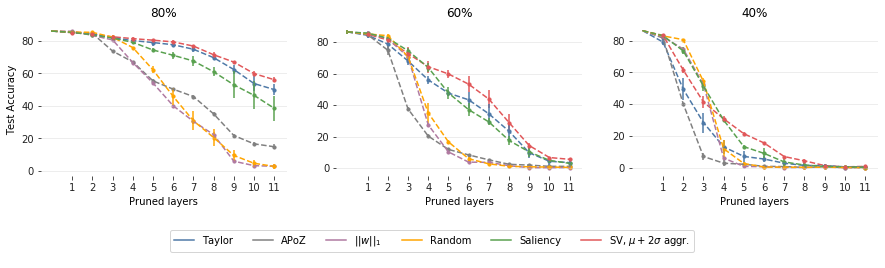

In [9]:
plot_data = pickle.load(open("data/lowdata_cub_performance_results_notune_det.p", "rb" ))


fig, axes = plt.subplots(1, 3, figsize=(15,4))
for idx, sparsity in enumerate([0.20, 0.40, 0.60]):
    
    print (sparsity)
    ax = axes[idx]
    pre_finetune = plot_data["pre"][sparsity]
    post_finetune = plot_data["post"][sparsity]
    methods = pre_finetune.keys()
    for method_name in pre_finetune.keys():
        
        label, color = map_method_vis(method_name)
        acc_pre_mean = 100 * np.array(pre_finetune[method_name]).mean(0)[:, 1]
        acc_pre_std = 100 * np.array(pre_finetune[method_name]).std(0)[:, 1]
        acc_post_mean = 100 * np.array(post_finetune[method_name]).mean(0)[:, 1]
        acc_post_std = 100 * np.array(post_finetune[method_name]).std(0)[:, 1]
        ticks = range(len(acc_pre_mean))
        max_layer = 11
        
        print (method_name)
        print (f"Pre tuning:\t{acc_pre_mean[max_layer]:.2f} +- {acc_pre_std[max_layer]:.2f}")
        print (f"Pst tuning:\t{acc_post_mean[max_layer-1]:.2f} +- {acc_post_std[max_layer-1]:.2f}")

        ax.scatter(ticks[1:max_layer+1], acc_post_mean[:max_layer], marker='o', s=10, color=color, zorder=100 if "SV" in label else 1)
        ax.errorbar(ticks[:max_layer+1], acc_pre_mean[:max_layer+1], acc_pre_std[:max_layer+1], color=color, linestyle="dashed")
        ax.plot([], [], label=label, color=color, linestyle="solid")
        format_plt(ax, f"{100-sparsity * 100:.0f}%", "Pruned layers", "Test Accuracy" if idx == 0 else "")
        plt.xticks(np.arange(1, 12, step=1))

        
handles, labels = plt.gca().get_legend_handles_labels()
handles, labels  = zip(*sorted(zip(handles, labels), key=lambda t: 1 if "SV" in t[1] else -1))
handles, labels  = zip(*sorted(zip(handles, labels), key=lambda t: 1 if "Fine" in t[1] else -1))

fig.subplots_adjust(bottom=.35)
fig.legend(handles, labels,loc='upper center', bbox_to_anchor=(0.40, 0.15), ncol=7)
plt.savefig(f"cub200_low_data_100_notune.pdf", bbox_inches='tight')